# Aim:
This notebook aims at analysing data issued from the trajectroy analysis.   

In [1]:
import lwfa_generics as LWFA
import numpy as np
import pylab as plt
import matplotlib
from lpa_pdb_diagnostics import *
from scipy.constants import e, c, m_e, epsilon_0
from matplotlib import rc, font_manager
import inspect
from lpa_pdb_diagnostics import *
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import pdb
import time
import os
import pandas

sizeOfFont = 12
fontProperties = {'family':'sans-serif','sans-serif':['Helvetica'],
    'weight' : 'bold', 'size' : sizeOfFont}
ticks_font = font_manager.FontProperties(family='sans-serif', style='normal',
    size=sizeOfFont, weight='bold')
#rc('text', usetex=True)
rc('font',**fontProperties)
dpi = 300

respath = config.result_path
%matplotlib inline


In [2]:
#Reading files and preparing data

numParticles = 200
numFiles = 20
totalNumParticles = numParticles * numFiles
numElectron = 2

particleN6 = []
particleN7 = []
part = 0

for xfiles in xrange(numFiles):
    fpN6 = FileReading("proba_a02_4e18_10fs_%d.hdf5" %( xfiles+1))
    instantprobaN6 = fpN6.read()
    fpN7 = FileReading("proba_a02_4e18_10fs_%d.hdf5"%( xfiles+1) )
    instantprobaN7 = fpN7.read()
    
    for x in xrange(numParticles):
        ffN6 = FileReading("part_a02_4e18_10fs_%d_0_%d.hdf5" %( xfiles+1, x))
        instantN6 = ffN6.read()

        ffN7 = FileReading("part_a02_4e18_10fs_%d_1_%d.hdf5" %(xfiles+1, x))
        instantN7 = ffN7.read()

        entryN6 = {'position' : np.transpose(instantN6["position"])[0], 
                'momentum' : np.transpose(instantN6["momentum"])[0], 
                'time' : np.transpose(instantN6["time"])[0],
                'proba' : instantprobaN6["552.0718"][x] ,
                'species' : 'N6' }
        entryN7 = {'position' : np.transpose(instantN7["position"])[0], 
                'momentum' : np.transpose(instantN7["momentum"])[0], 
                'time' : np.transpose(instantN7["time"])[0],
                'proba' : instantprobaN7["667.046"][x] ,
                'species' : 'N7' }
        particleN6.append(entryN6)
        particleN7.append(entryN7)
        #pdb.set_trace()
        part += 1

In [3]:
# Creating pandas dataframe for two species of particles N6,N7
dfN6 = pandas.DataFrame(data = particleN6)
dfN7 = pandas.DataFrame(data = particleN7)

In [4]:
# Combining pandas dataframe
df = pandas.concat([dfN6,dfN7])

In [5]:
#Preparing last energy and first position arrays
last_gammaN6 = np.empty(totalNumParticles)
last_gammaN7 = np.empty(totalNumParticles)
fist_positionN6 = np.empty(totalNumParticles)
fist_positionN7 = np.empty(totalNumParticles)

for part in xrange(totalNumParticles):
    
    last_gammaN6[part] = np.sqrt(1 + dfN6["momentum"].iloc[part][-1]**2)
    fist_positionN6[part] = dfN6["position"].iloc[part][0]*1e6
    
    last_gammaN7[part]  = np.sqrt(1 + dfN7["momentum"].iloc[part][-1]**2)
    fist_positionN7[part]  = dfN7["position"].iloc[part][0]*1e6

last_energyN6 = gamma2Energy(np.array(last_gammaN6))
last_energyN7  = gamma2Energy(np.array(last_gammaN7))

In [6]:
# Grouping by Proba, preparing the array
min_proba  = np.min(map(lambda x: np.min(x), df["proba"] ))
num_group_proba = 5
proba_group = np.linspace( min_proba, 1, num_group_proba )
mid_proba_group = (proba_group[:-1] +proba_group[1:])/2

In [7]:
#Determine the max time among all the particles for grouping purpose
max_time  = np.max(map(lambda x: np.max(x), df["time"] ))

In [8]:
# Grouping particles according to their time*c in the propagation

numGroup = 20
z_array = np.linspace(0, max_time*c, numGroup) 
gamma_array = [[[] for x in xrange(len(z_array)-1)] for y in xrange(numElectron)]
position_array = [[[] for x in xrange(len(z_array)-1)] for y in xrange(numElectron)]
proba_array = [[[] for x in xrange(len(z_array)-1)] for y in xrange(numElectron)]

#Determine the midpint of the distance
mid_iz_array = (z_array[1:] + z_array[:-1])/2
num_iz = len(mid_iz_array)

for iz in range(0, len(z_array) - 1):
    ie =0
    
    for irow, row in dfN6.iterrows():
        index = np.compress(np.logical_and(np.array(row['time'])*c>z_array[iz],
                                               np.array(row['time'])*c<=z_array[iz+1] ), 
                                np.arange(len(row['time'])))
        gamma = np.sqrt(1 + row['momentum'][index]**2)
        gamma_array[ie][iz].extend(gamma)
        position_array[ie][iz].extend(row['position'][index] )
        proba_array[ie][iz].append(row['proba'])
    ie +=1
    
    for irow, row in dfN7.iterrows():
        index = np.compress(np.logical_and(np.array(row['time'])*c>z_array[iz],
                                               np.array(row['time'])*c<=z_array[iz+1] ), 
                                np.arange(len(row['time'])))
        gamma = np.sqrt(1 + row['momentum'][index]**2)
        gamma_array[ie][iz].extend(gamma)
        position_array[ie][iz].extend(row['position'][index] )
        proba_array[ie][iz].append(row['proba'])
        

In [9]:
# Plotting parameters
leg = [r"$\mathrm{N6}$", r"$\mathrm{N7}$"]
marker =["+", "x"]

xcolor = np.arange(num_iz*numElectron)
ys = [i+xcolor+(i*xcolor)**2 for i in range(num_iz*numElectron)]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))

/home/patrick/miniconda2/lib/python2.7/site-packages/matplotlib-2.0.0b3-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


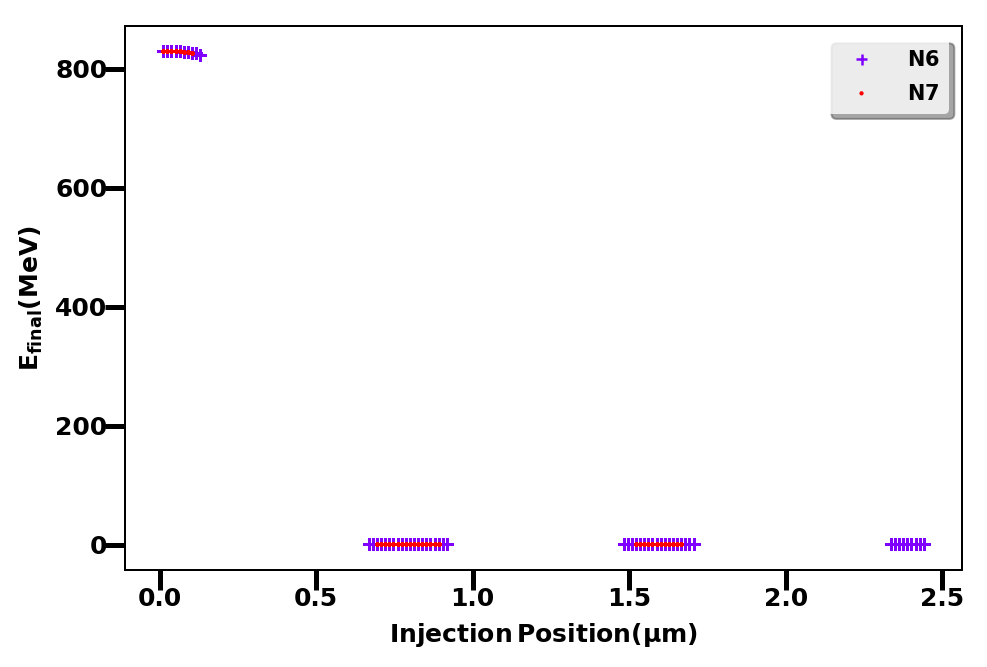

In [10]:
# PLOT: Final energy vs position of injection
fig, ax = plt.subplots( dpi = 180 )
fig.patch.set_facecolor('white')

ax.scatter(fist_positionN6[0], last_energyN6[0], 
                   linewidth=1, marker = marker[0], color = colors[0], s=20, 
                   label =leg[0])
ax.scatter(fist_positionN7[0], last_energyN7[0], 
                   linewidth=1, marker = ".", color = colors[-1], s=2, 
                   label =leg[1])
        
ax.scatter(fist_positionN6[1::], last_energyN6[1::], 
                   linewidth=1, marker = marker[0], color = colors[0], s=20)
ax.scatter(fist_positionN7[1::], last_energyN7[1::], 
                   linewidth=1, marker = ".", color = colors[-1], s=2)
     
#ax.set_xlim(min(x)*kp/(2*np.pi), max(x)*kp/(2*np.pi))
ax.set_ylabel(r"$\mathrm{E_{final}(MeV)}$")
ax.set_xlabel(r"$\mathrm{Injection\,Position(\mu m)}$")

ax.xaxis.set_tick_params(width=2, length = 8)
ax.yaxis.set_tick_params(width=2, length = 8)
font = {'family':'sans-serif'}
plt.rc('font', **font)

if leg is not None:
    # Now add the legend with some customizations.
    legend = plt.legend(loc='best', shadow=True)

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('small')

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width


In [39]:
# Preparing beam statistics (beam average energy, energy spread, count)

avgEnergy = np.zeros([numElectron, len(mid_iz_array)])
avgPosition = np.zeros([numElectron, len(mid_iz_array)])
eSpread = np.zeros([numElectron, len(mid_iz_array)])
count = np.zeros([numElectron, len(mid_iz_array)])

c_avgEnergy = np.zeros([numElectron, len(mid_iz_array)])
c_avgPosition = np.zeros([numElectron, len(mid_iz_array)])
c_eSpread = np.zeros([numElectron, len(mid_iz_array)])
c_count = np.zeros([numElectron, len(mid_iz_array)])

N_injection = 2 #index of the frame that indicates the end of injection
eSpread_proba = []
count_proba = []
avgEnergy_proba = []
avgPosition_proba = []

for ie in xrange(numElectron):
    for index in xrange(len(mid_iz_array)):
        energy = gamma2Energy(np.array(gamma_array[ie][index]))
        w = np.ones(len(energy))
        avgEnergy[ie][index] = wavg(energy, w)
        avgPosition[ie][index] = np.mean( position_array[ie][index] )
        variance = np.average( (energy - avgEnergy[ie][index])**2, weights = w)
        deltaE = np.sqrt( variance )
        
        eSpread[ie][index] = deltaE/avgEnergy[ie][index]
        count[ie][index] = len(energy)
        
        #cumulative
        #print max(0,index-N_injection), index + 1
        c_gamma = np.hstack(np.array(gamma_array[ie][max(0,index-N_injection):index + 1 ])).flatten()
        
        c_energy = gamma2Energy(c_gamma)
        c_w = np.ones(len((c_energy)))
        c_avgEnergy[ie][index] = wavg(c_energy, c_w)
        
        c_position_array = np.hstack(np.array(position_array[ie][max(0,index-N_injection):index + 1])).flatten()
        c_avgPosition[ie][index] = np.mean(c_position_array )
        c_variance = np.average( (c_energy.flatten() - c_avgEnergy[ie][index])**2, weights = c_w)
        c_deltaE = np.sqrt( variance )
        
        c_eSpread[ie][index] = c_deltaE/c_avgEnergy[ie][index]
        c_count[ie][index] = len(c_energy)
        
        #for iproba in xrange(len(mid_proba_group)):
            
        #    index_proba = np.compress( np.logical_and(proba_array[ie][index]>proba_group[iproba], 
        #                                              proba_array[ie][index]<=proba_group[iproba+1]),
        #                              np.arange(len(proba_array[ie][index])))
            
        #    e_proba = np.take(energy, index_proba)
        #    w_proba = np.ones(len(e_proba))
        #    avgEnergy_proba.extend(wavg(e_proba, w_proba)) 
        #    avgPosition.extend(np.mean( position_array[ie][index][index_proba] ))
        #    variance = np.average( (e_proba - avgEnergy_proba[iproba])**2, weights = w_proba)
        #    deltaE = np.sqrt( variance )
        #    eSpread_proba.extend(deltaE/avgEnergy_proba[iproba])
        #    count_proba.extend(len(e_proba))

0 1
0 2
0 3
1 4
2 5
3 6
4 7
5 8
6 9
7 10
8 11
9 12
10 13
11 14
12 15
13 16
14 17
15 18
16 19
0 1
0 2
0 3
1 4
2 5
3 6
4 7
5 8
6 9
7 10
8 11
9 12
10 13
11 14
12 15
13 16
14 17
15 18
16 19


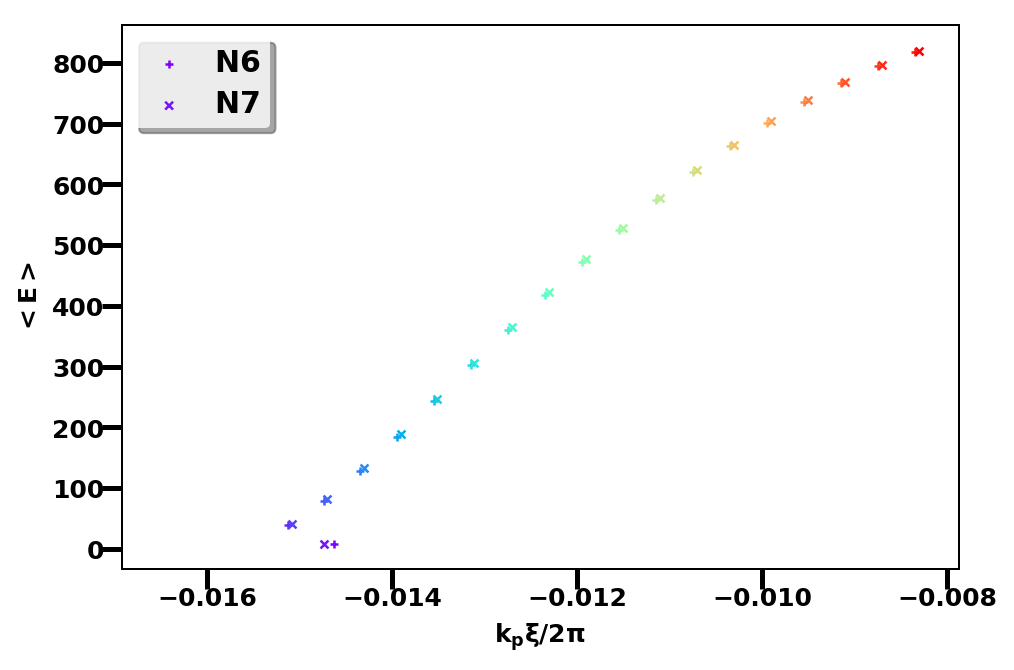

In [40]:
# PLOT: Average energy by group vs average position (xi) by group

fig, ax = plt.subplots( dpi = 180 )
fig.patch.set_facecolor('white')

ip = 0
for iz in xrange( len(mid_iz_array)):
    for ie in xrange(numElectron):
        if iz ==0:
            ax.scatter(np.array(avgPosition[ie][iz])*1e3, avgEnergy[ie][iz], 
                   linewidth=1, marker = marker[ie], color = colors[ip], s=10, label=leg[ie])
        else:
            ax.scatter(np.array(avgPosition[ie][iz])*1e3, avgEnergy[ie][iz], 
                   linewidth=1, marker = marker[ie], color = colors[ip], s=10)
        ip+=1

#ax.set_xlim(min(x)*kp/(2*np.pi), max(x)*kp/(2*np.pi))
ax.set_xlabel(r"$\mathrm{k_p\xi/2\pi}$")
ax.set_ylabel(r"$\mathrm{<E>}$")

ax.xaxis.set_tick_params(width=2, length = 8)
ax.yaxis.set_tick_params(width=2, length = 8)
font = {'family':'sans-serif'}
plt.rc('font', **font)

if leg is not None:
    # Now add the legend with some customizations.
    legend = plt.legend(loc='best', shadow=True)

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width


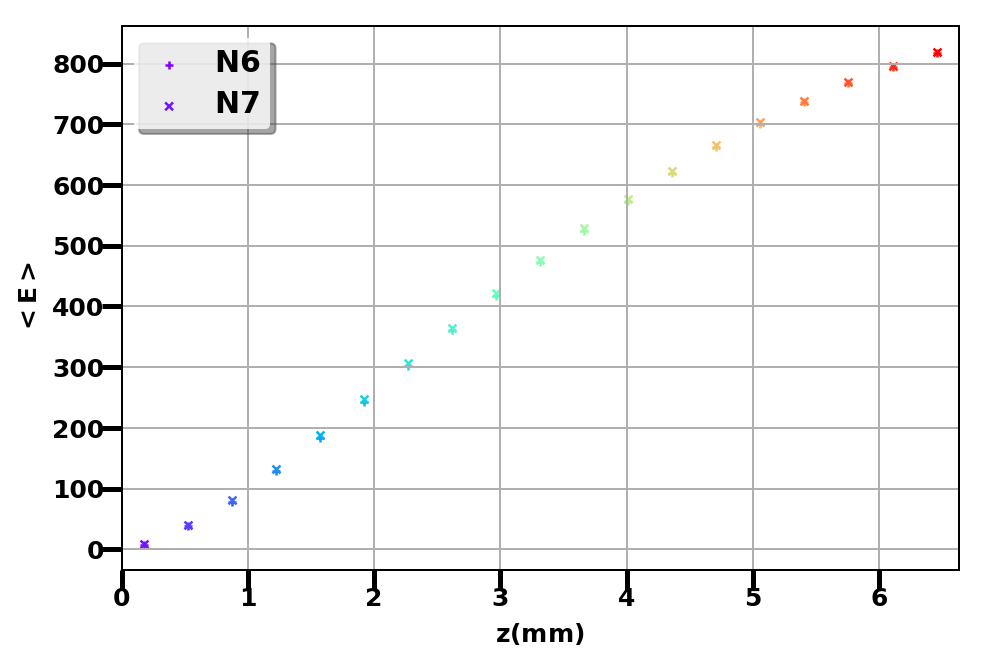

In [48]:
# PLOT: Average energy by group vs propagation length (z) by group

fig, ax = plt.subplots( dpi = 180 )
fig.patch.set_facecolor('white')

ip = 0
for iz in xrange( len(mid_iz_array)):
    for ie in xrange(numElectron):
        if iz ==0:
            ax.scatter(np.array(mid_iz_array[iz])*1e3, avgEnergy[ie][iz], 
                   linewidth=1, marker = marker[ie], color = colors[ip], s=10, label=leg[ie])
        else:
            ax.scatter(np.array(mid_iz_array[iz])*1e3, avgEnergy[ie][iz], 
                   linewidth=1, marker = marker[ie], color = colors[ip], s=10)
        ip+=1

#ax.set_xlim(min(x)*kp/(2*np.pi), max(x)*kp/(2*np.pi))
ax.set_xlabel(r"$\mathrm{z (mm)}$")
ax.set_ylabel(r"$\mathrm{<E>}$")
ax.set_xlim(0,(max_time*c*1e3))

ax.xaxis.set_tick_params(width=2, length = 8)
ax.yaxis.set_tick_params(width=2, length = 8)
font = {'family':'sans-serif'}
plt.rc('font', **font)

if leg is not None:
    # Now add the legend with some customizations.
    legend = plt.legend(loc='best', shadow=True)

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
plt.grid()

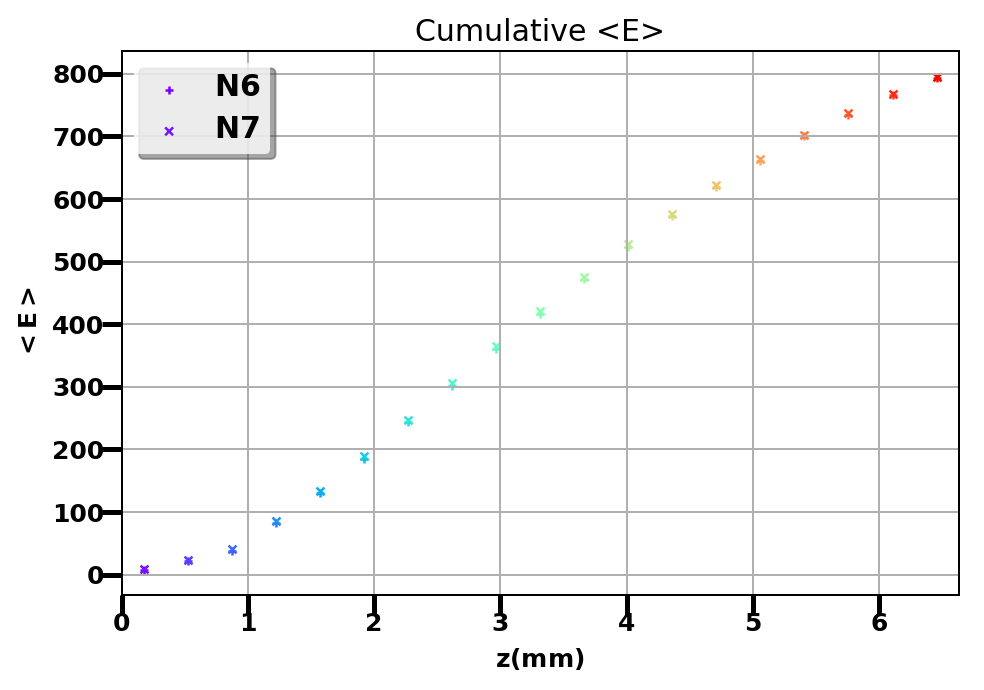

In [42]:
# PLOT: Average energy by group vs propagation length (z) by group

fig, ax = plt.subplots( dpi = 180 )
fig.patch.set_facecolor('white')

ip = 0
for iz in xrange( len(mid_iz_array)):
    for ie in xrange(numElectron):
        if iz ==0:
            ax.scatter(np.array(mid_iz_array[iz])*1e3, c_avgEnergy[ie][iz], 
                   linewidth=1, marker = marker[ie], color = colors[ip], s=10, label=leg[ie])
        else:
            ax.scatter(np.array(mid_iz_array[iz])*1e3, c_avgEnergy[ie][iz], 
                   linewidth=1, marker = marker[ie], color = colors[ip], s=10)
        ip+=1

#ax.set_xlim(min(x)*kp/(2*np.pi), max(x)*kp/(2*np.pi))
ax.set_xlabel(r"$\mathrm{z (mm)}$")
ax.set_ylabel(r"$\mathrm{<E>}$")

ax.set_xlim(0,(max_time*c*1e3))
ax.xaxis.set_tick_params(width=2, length = 8)
ax.yaxis.set_tick_params(width=2, length = 8)
font = {'family':'sans-serif'}
plt.rc('font', **font)
plt.title("Cumulative <E>")

if leg is not None:
    # Now add the legend with some customizations.
    legend = plt.legend(loc='best', shadow=True)

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
plt.grid()

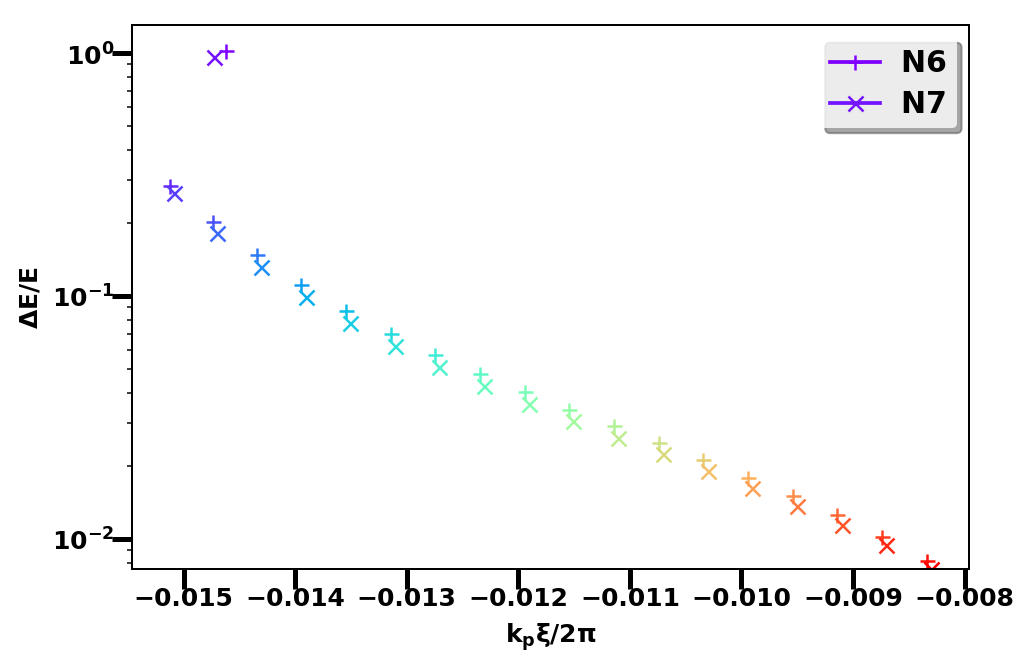

In [43]:
# PLOT: Energy spread by group vs average position (xi) by group

fig, ax = plt.subplots( dpi = 180 )
fig.patch.set_facecolor('white')

ip = 0
for iz in xrange( len(mid_iz_array)):
    for ie in xrange(numElectron):
        if iz ==0:
            #ax.scatter(np.array(avgPosition[ie][iz])*1e3,  eSpread[ie][iz], 
            #       linewidth=1, marker = marker[ie], color = colors[ip], s=10, label=leg[ie])
            ax.semilogy(np.array(avgPosition[ie][iz])*1e3,  eSpread[ie][iz], 
                   linewidth=1, marker = marker[ie], color = colors[ip],  label=leg[ie])
        else:
            #ax.scatter(np.array(avgPosition[ie][iz])*1e3, eSpread[ie][iz],  linewidth=1,
            #       marker = marker[ie], color = colors[ip], s=10)
            ax.semilogy(np.array(avgPosition[ie][iz])*1e3, eSpread[ie][iz],  linewidth=1,
                   marker = marker[ie], color = colors[ip])
        ip+=1

#ax.set_xlim(min(x)*kp/(2*np.pi), max(x)*kp/(2*np.pi))
ax.set_xlabel(r"$\mathrm{k_p\xi/2\pi}$")
ax.set_ylabel(r"$\mathrm{\Delta E/E}$")

ax.xaxis.set_tick_params(width=2, length = 8)
ax.yaxis.set_tick_params(width=2, length = 8)
font = {'family':'sans-serif'}
plt.rc('font', **font)

if leg is not None:
    # Now add the legend with some customizations.
    legend = plt.legend(loc='best', shadow=True)

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width


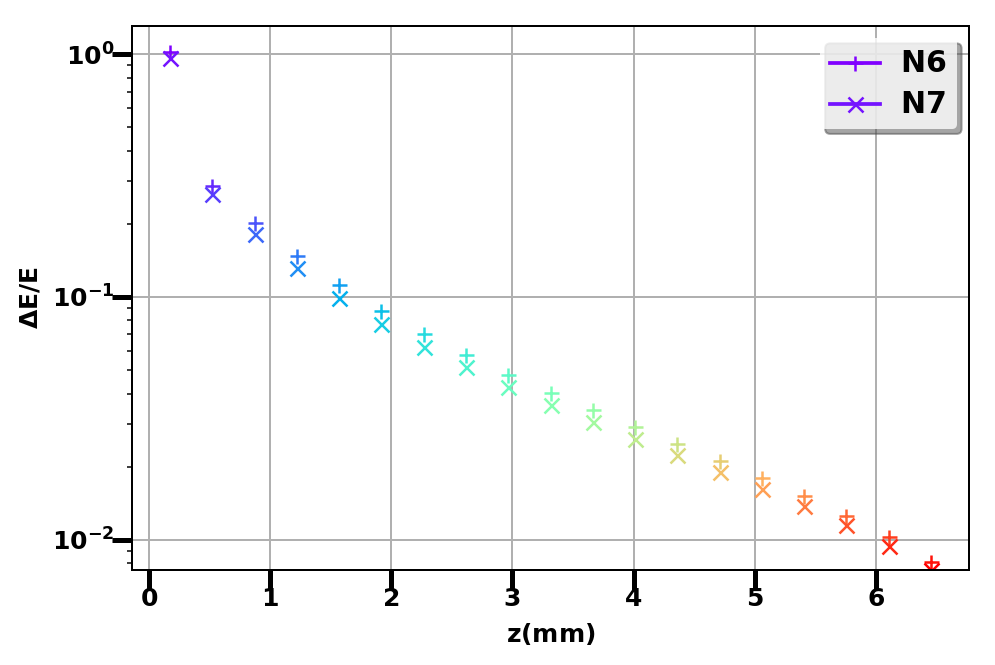

In [47]:
# PLOT: Energy spread by group vs propagation length (z) by group

fig, ax = plt.subplots( dpi = 180 )
fig.patch.set_facecolor('white')

ip = 0
for iz in xrange( len(mid_iz_array)):
    for ie in xrange(numElectron):
        if iz ==0:
            #ax.scatter(np.array(mid_iz_array[iz])*1e3,  eSpread[ie][iz], 
            #       linewidth=1, marker = marker[ie], color = colors[ip], s=10, label=leg[ie])
            ax.semilogy(np.array(mid_iz_array[iz])*1e3,  eSpread[ie][iz], 
                   linewidth=1, marker = marker[ie], color = colors[ip], label=leg[ie])
        else:
            #ax.scatter(np.array(mid_iz_array[iz])*1e3, eSpread[ie][iz],  linewidth=1,
            #       marker = marker[ie], color = colors[ip], s=10)
            ax.semilogy(np.array(mid_iz_array[iz])*1e3, eSpread[ie][iz],  linewidth=1,
                   marker = marker[ie], color = colors[ip])
        ip+=1

#ax.set_xlim(min(x)*kp/(2*np.pi), max(x)*kp/(2*np.pi))
ax.set_xlabel(r"$\mathrm{z (mm)}$")
ax.set_ylabel(r"$\mathrm{\Delta E/E}$")

ax.xaxis.set_tick_params(width=2, length = 8)
ax.yaxis.set_tick_params(width=2, length = 8)
font = {'family':'sans-serif'}
plt.rc('font', **font)

if leg is not None:
    # Now add the legend with some customizations.
    legend = plt.legend(loc='best', shadow=True)

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
plt.grid()

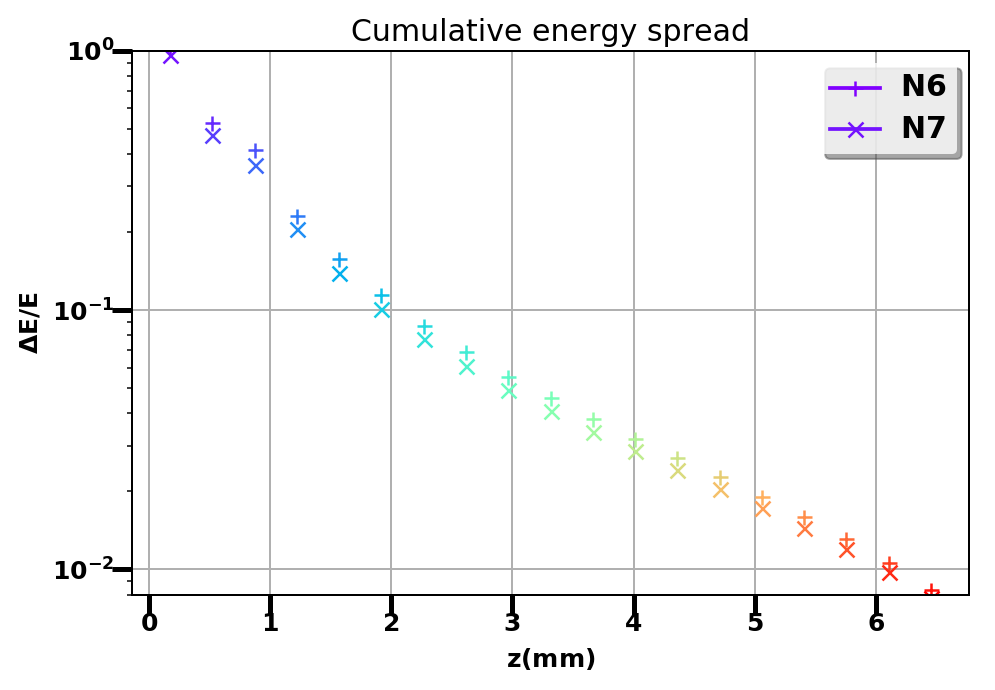

In [45]:
# PLOT: Cumulative Energy spread by group vs propagation length (z) by group

fig, ax = plt.subplots( dpi = 180 )
fig.patch.set_facecolor('white')

ip = 0
for iz in xrange( len(mid_iz_array)):
    for ie in xrange(numElectron):
        if iz ==0:
            #ax.scatter(np.array(mid_iz_array[iz])*1e3,  eSpread[ie][iz], 
            #       linewidth=1, marker = marker[ie], color = colors[ip], s=10, label=leg[ie])
            ax.semilogy(np.array(mid_iz_array[iz])*1e3,  c_eSpread[ie][iz], 
                   linewidth=1, marker = marker[ie], color = colors[ip], label=leg[ie])
        else:
            #ax.scatter(np.array(mid_iz_array[iz])*1e3, eSpread[ie][iz],  linewidth=1,
            #       marker = marker[ie], color = colors[ip], s=10)
            ax.semilogy(np.array(mid_iz_array[iz])*1e3, c_eSpread[ie][iz],  linewidth=1,
                   marker = marker[ie], color = colors[ip])
        ip+=1

#ax.set_xlim(min(x)*kp/(2*np.pi), max(x)*kp/(2*np.pi))
ax.set_xlabel(r"$\mathrm{z (mm)}$")
ax.set_ylabel(r"$\mathrm{\Delta E/E}$")

ax.xaxis.set_tick_params(width=2, length = 8)
ax.yaxis.set_tick_params(width=2, length = 8)
ax.set_ylim(8e-3,1)
font = {'family':'sans-serif'}
plt.rc('font', **font)
plt.title("Cumulative energy spread")

if leg is not None:
    # Now add the legend with some customizations.
    legend = plt.legend(loc='best', shadow=True)

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
plt.grid()

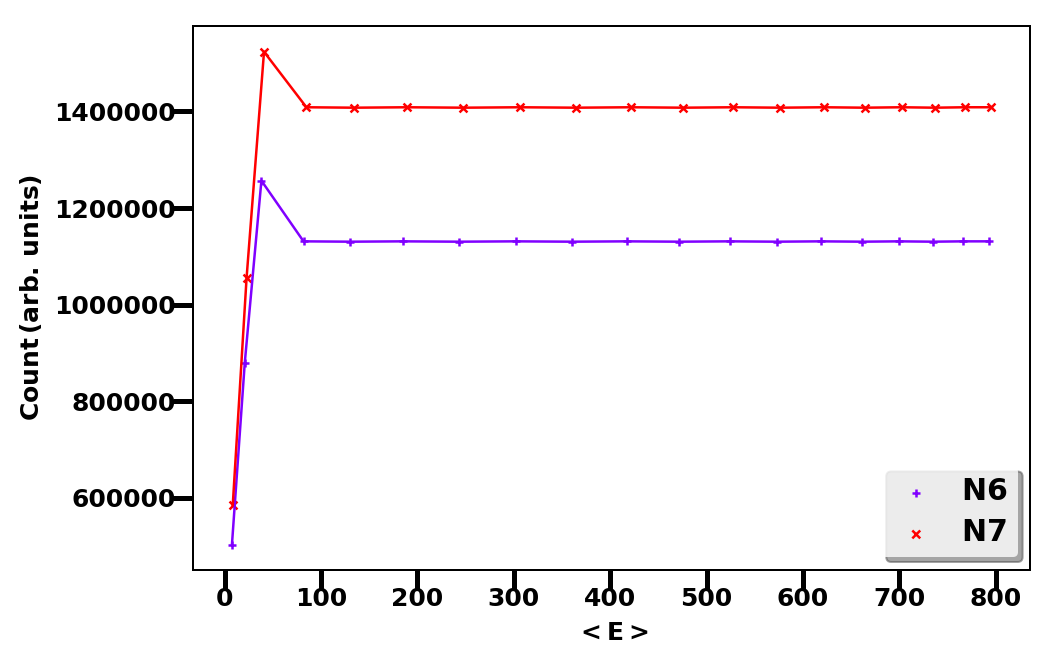

In [46]:
# PLOT: Energy distribution by group
fig, ax = plt.subplots( dpi = 180 )
fig.patch.set_facecolor('white')


for ie in xrange(numElectron):

    if ie ==0:
        colors_ie = colors[0] 
  
        ax.scatter(np.array(c_avgEnergy[ie][0]),  c_count[ie][0], 
                   linewidth=1, marker = marker[ie], color = colors_ie, s=10,
                       label = leg[0])

        ax.scatter(np.array(c_avgEnergy[ie][1:]),  c_count[ie][1:], 
                   linewidth=1, marker = marker[ie], color = colors_ie, s=10)
        ax.plot(np.array(c_avgEnergy[ie]), c_count[ie],  linewidth=1,
                   color = colors_ie)
    else:
        colors_ie = colors[-1] 

        ax.scatter(np.array(c_avgEnergy[ie][0]),  c_count[ie][0], 
                linewidth=1, marker = marker[ie], color = colors_ie, s=10,
                  label = leg[1])
        
        ax.scatter(np.array(c_avgEnergy[ie][1:]),  c_count[ie][1:], 
                linewidth=1, marker = marker[ie], color = colors_ie, s=10)
        
        ax.plot(np.array(c_avgEnergy[ie]), c_count[ie],  linewidth=1,
                   color = colors_ie)


#ax.set_xlim(min(x)*kp/(2*np.pi), max(x)*kp/(2*np.pi))
ax.set_xlabel(r"$\mathrm{<E>}$")
ax.set_ylabel(r"$\mathrm{Count\,(arb.\,units)}$")

ax.xaxis.set_tick_params(width=2, length = 8)
ax.yaxis.set_tick_params(width=2, length = 8)
font = {'family':'sans-serif'}
plt.rc('font', **font)

if leg is not None:
    # Now add the legend with some customizations.
    legend = plt.legend(loc='best', shadow=True)

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
